<a href="https://colab.research.google.com/github/mohatsim786/wellbore-profile-prediction/blob/main/Shape_and_all_regression_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mean
import shap
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Load data
data = pd.read_excel('/content/CAL.xlsx')
# Alternatively: data = pd.read_excel('/content/calliper.xlsx')

# Prepare features and target
X = data.iloc[:, :-1]                         # All columns except last as features
Y = 100. * data.iloc[:, 17]                   # 18th column (scaled)

# Train-test split
X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Initialize SHAP visualization
shap.initjs()

Linear_Regression

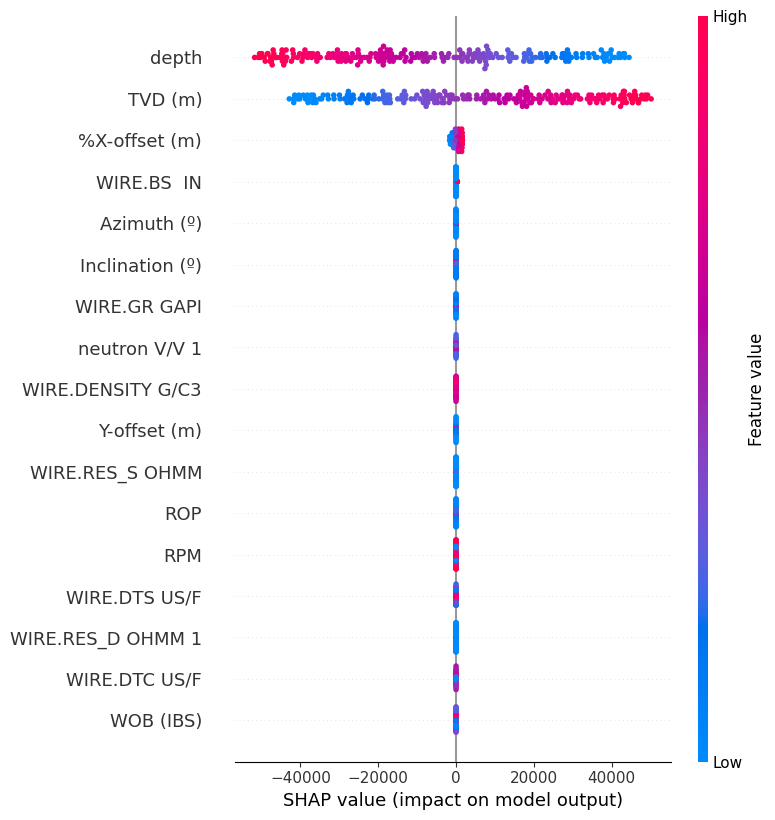

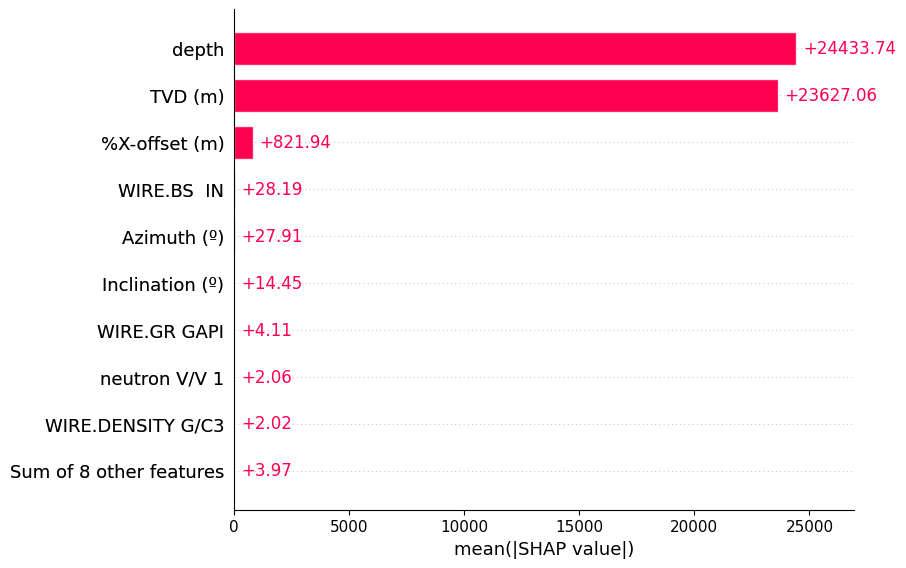

depth               -6670.981998
WIRE.BS  IN           -11.419672
Azimuth (º)            -9.471626
Y-offset (m)           -0.268532
WIRE.RES_S OHMM        -0.233485
neutron V/V 1          -0.127465
WIRE.DTS US/F           0.004667
WOB (IBS)               0.008023
WIRE.DTC US/F           0.026565
RPM                     0.081808
WIRE.RES_D OHMM 1       0.109911
ROP                     0.133144
WIRE.GR GAPI            0.201204
WIRE.DENSITY G/C3       0.369925
Inclination (º)         4.253935
%X-offset (m)         240.841022
TVD (m)              6434.179425
dtype: float64


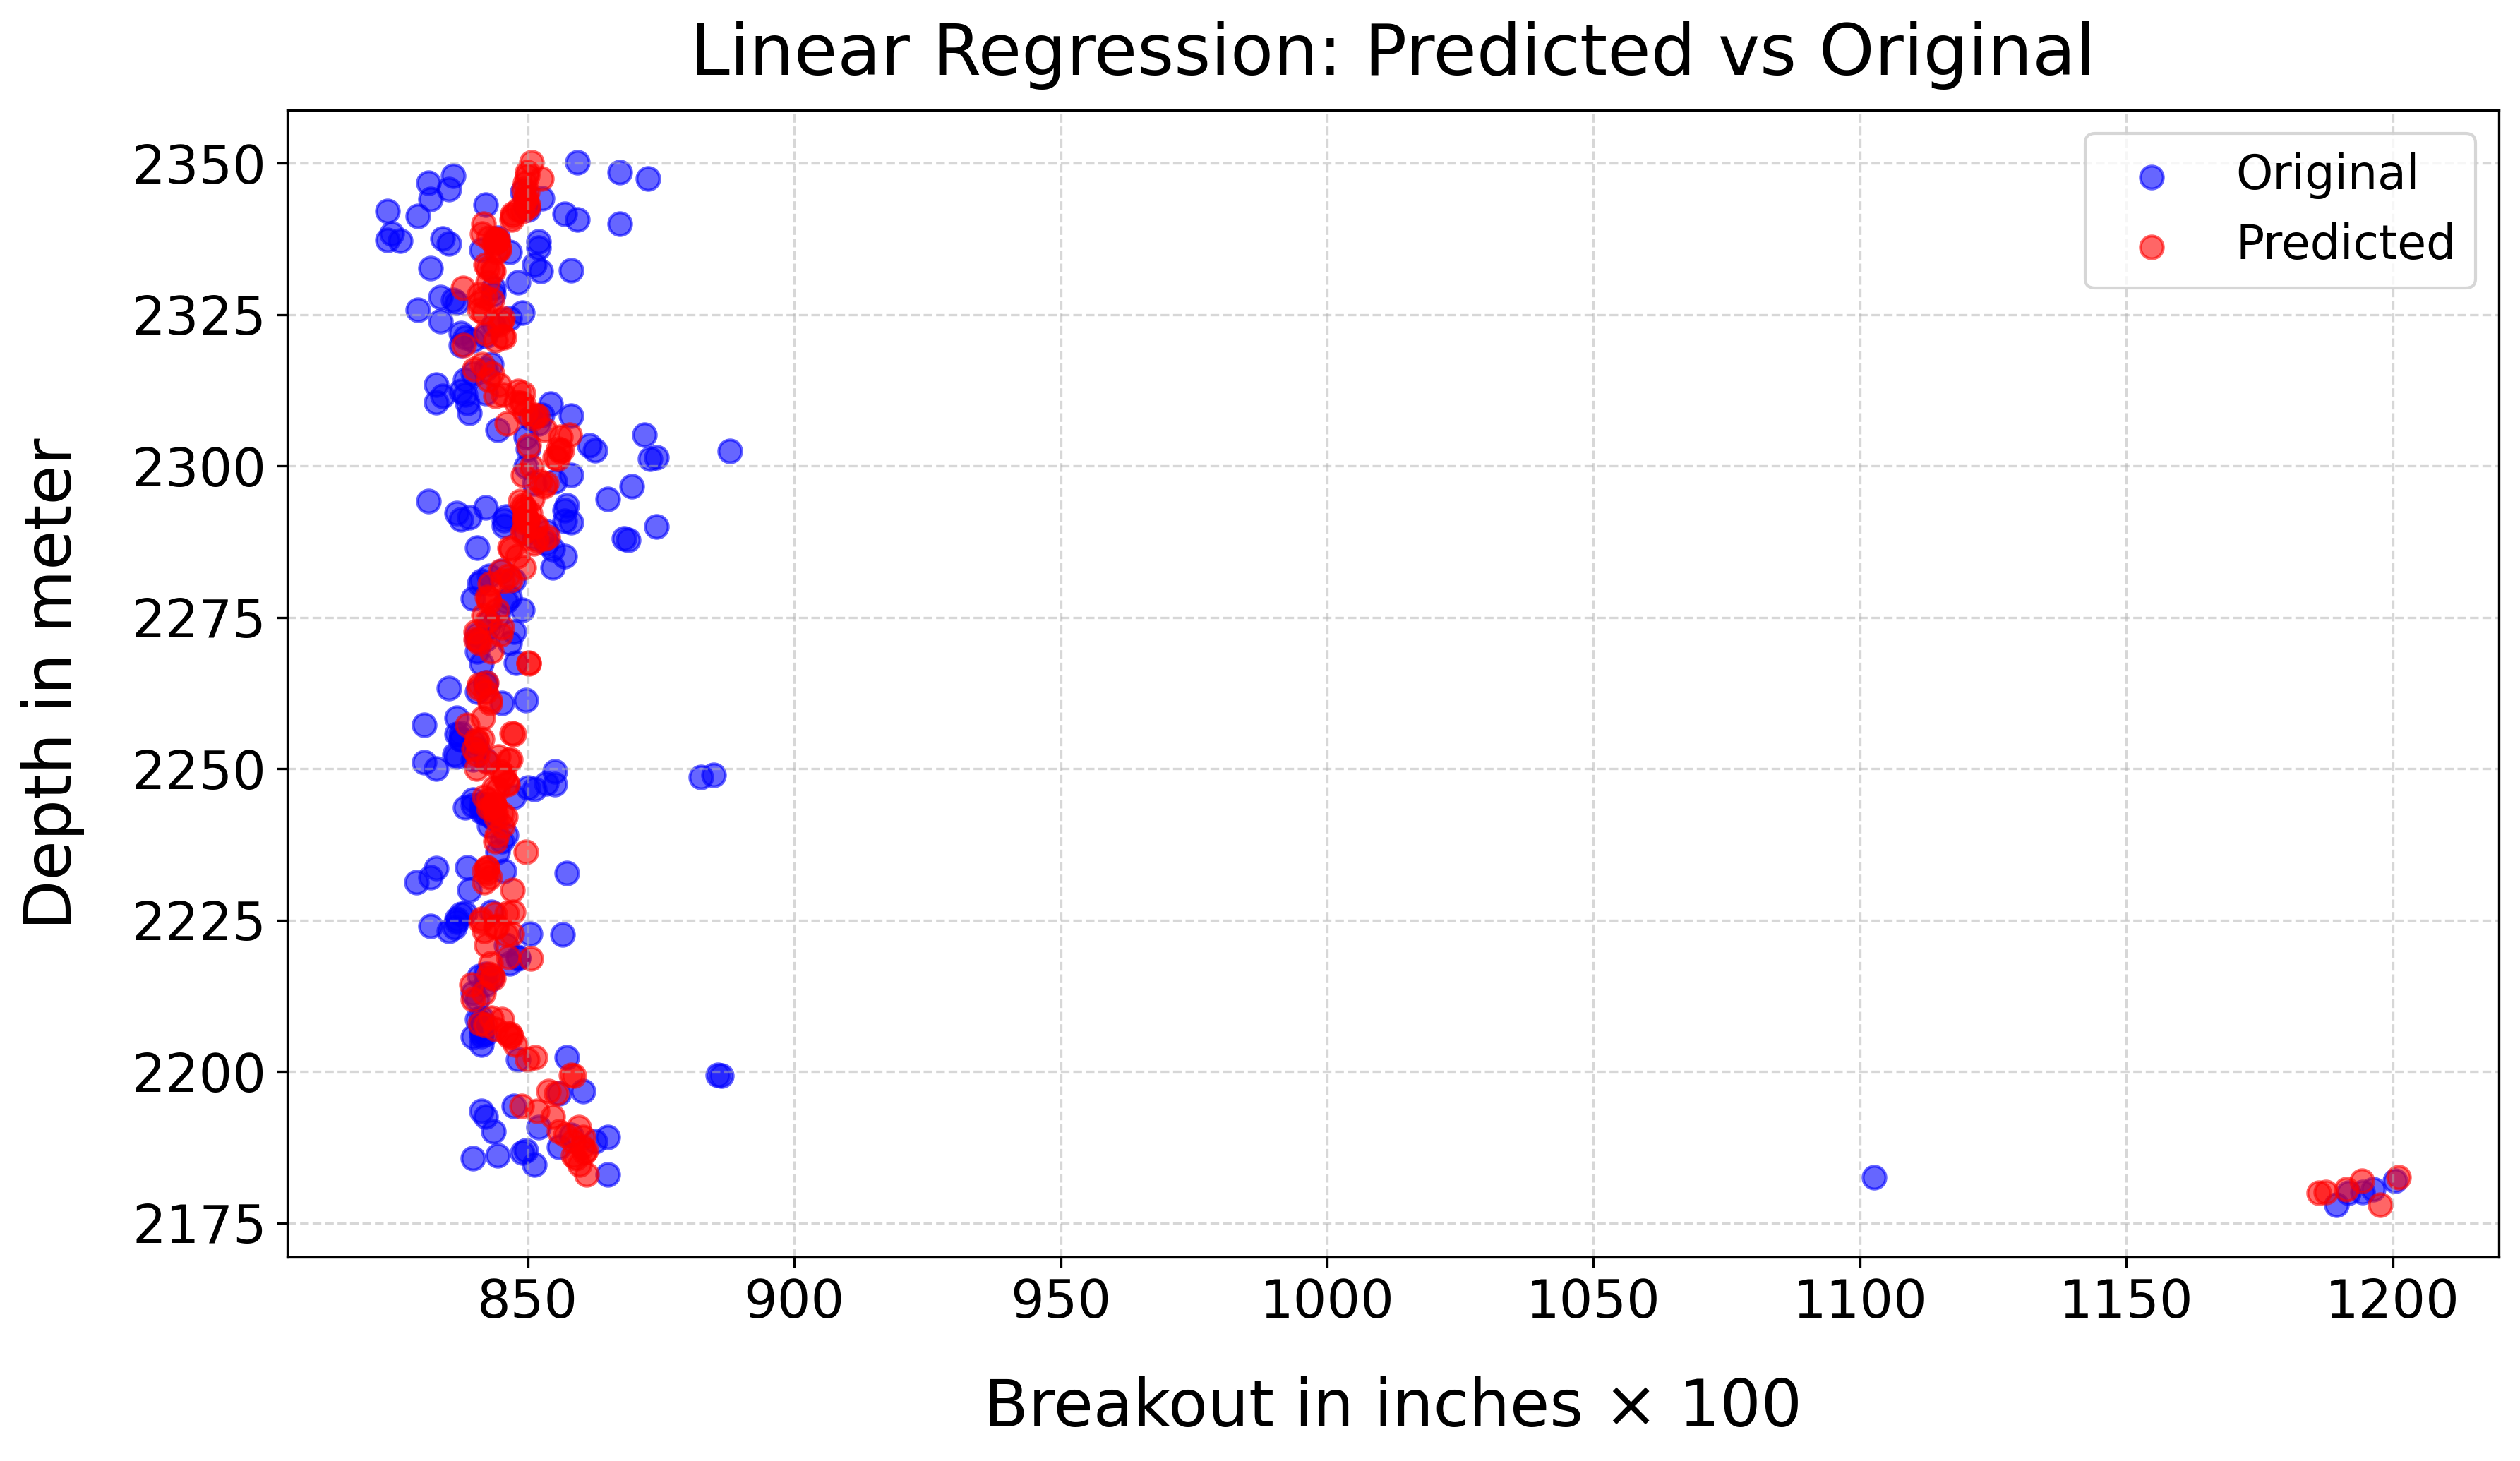

In [2]:
from sklearn.linear_model import LinearRegression
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Train Linear Regression model
lr = LinearRegression()
lr.fit(X_Train, Y_Train)
Y_PreLR = lr.predict(X_Test)

# Initialize SHAP explainer and compute SHAP values
shap.initjs()
explainer = shap.Explainer(lr, X_Train)
shap_values = explainer(X_Test)

# SHAP visualizations
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Force plot for the first instance

# Convert SHAP values to DataFrame and compute feature importance
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Test.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)

# Save mean SHAP values to CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv('mean_shap_values.csv', index=False)

# Print mean SHAP values
print(mean_shap_values)

# Plot: Predicted vs Original (Breakout vs Depth)
plt.figure(figsize=(12, 7), dpi=300)

# Depth on y-axis (assuming first column is depth)
depth = X_Test.iloc[:, 0]
plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(Y_PreLR, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("Linear Regression: Predicted vs Original", fontsize=24, pad=12)

# Tick sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and display the plot
plt.savefig("Linear_Regression_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Polynomial_Regression

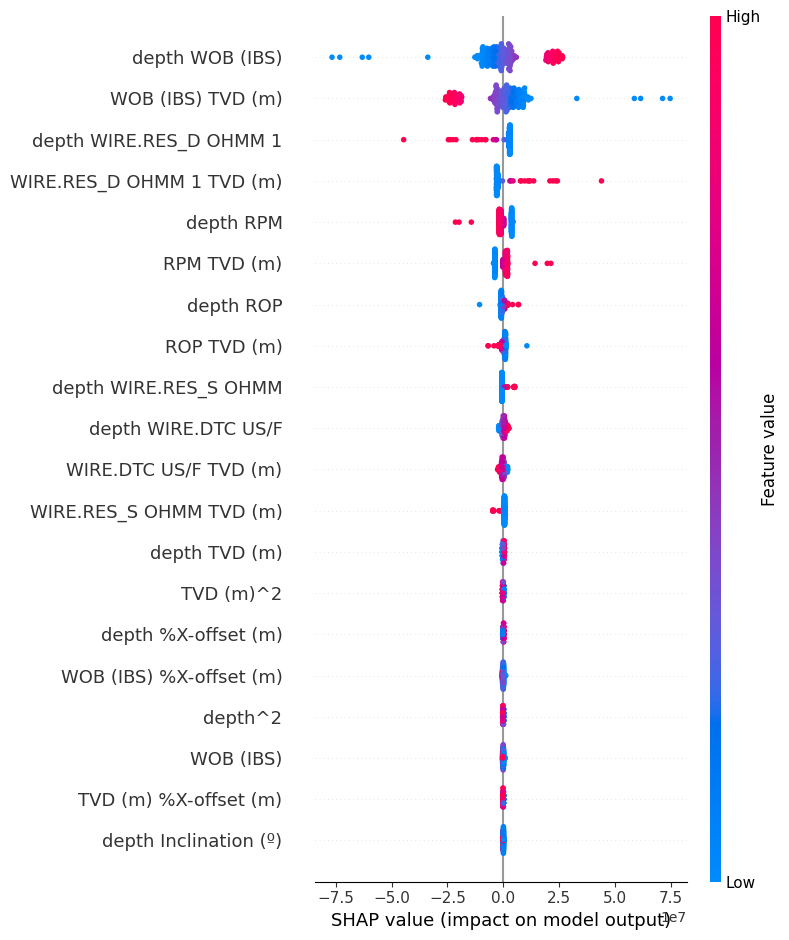

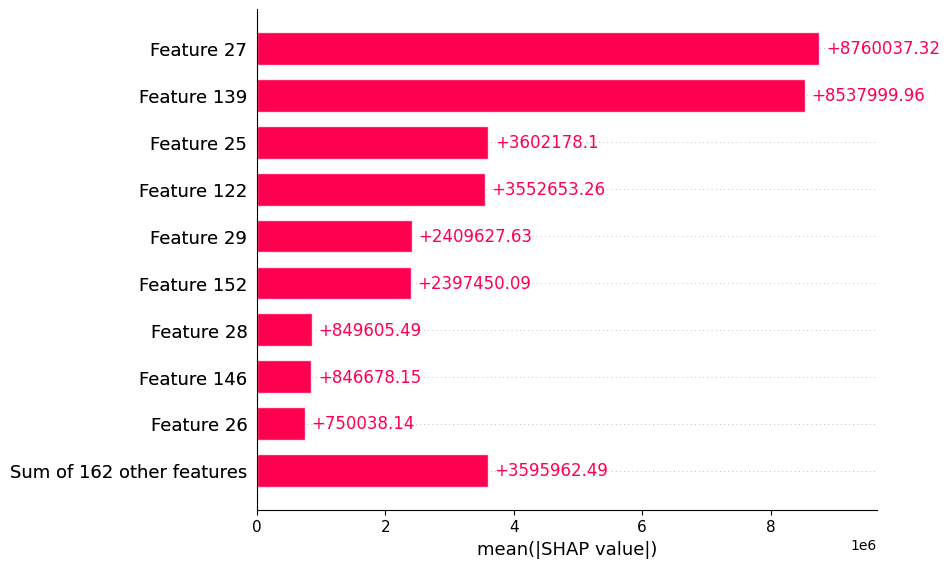

WIRE.RES_D OHMM 1 TVD (m)   -1.632787e+06
WOB (IBS) TVD (m)           -7.174926e+05
RPM TVD (m)                 -3.448897e+05
depth WIRE.RES_S OHMM       -3.267975e+05
depth ROP                   -2.274936e+05
                                 ...     
ROP TVD (m)                  2.267757e+05
WIRE.RES_S OHMM TVD (m)      2.990163e+05
depth RPM                    3.461878e+05
depth WOB (IBS)              7.362541e+05
depth WIRE.RES_D OHMM 1      1.655530e+06
Length: 171, dtype: float64


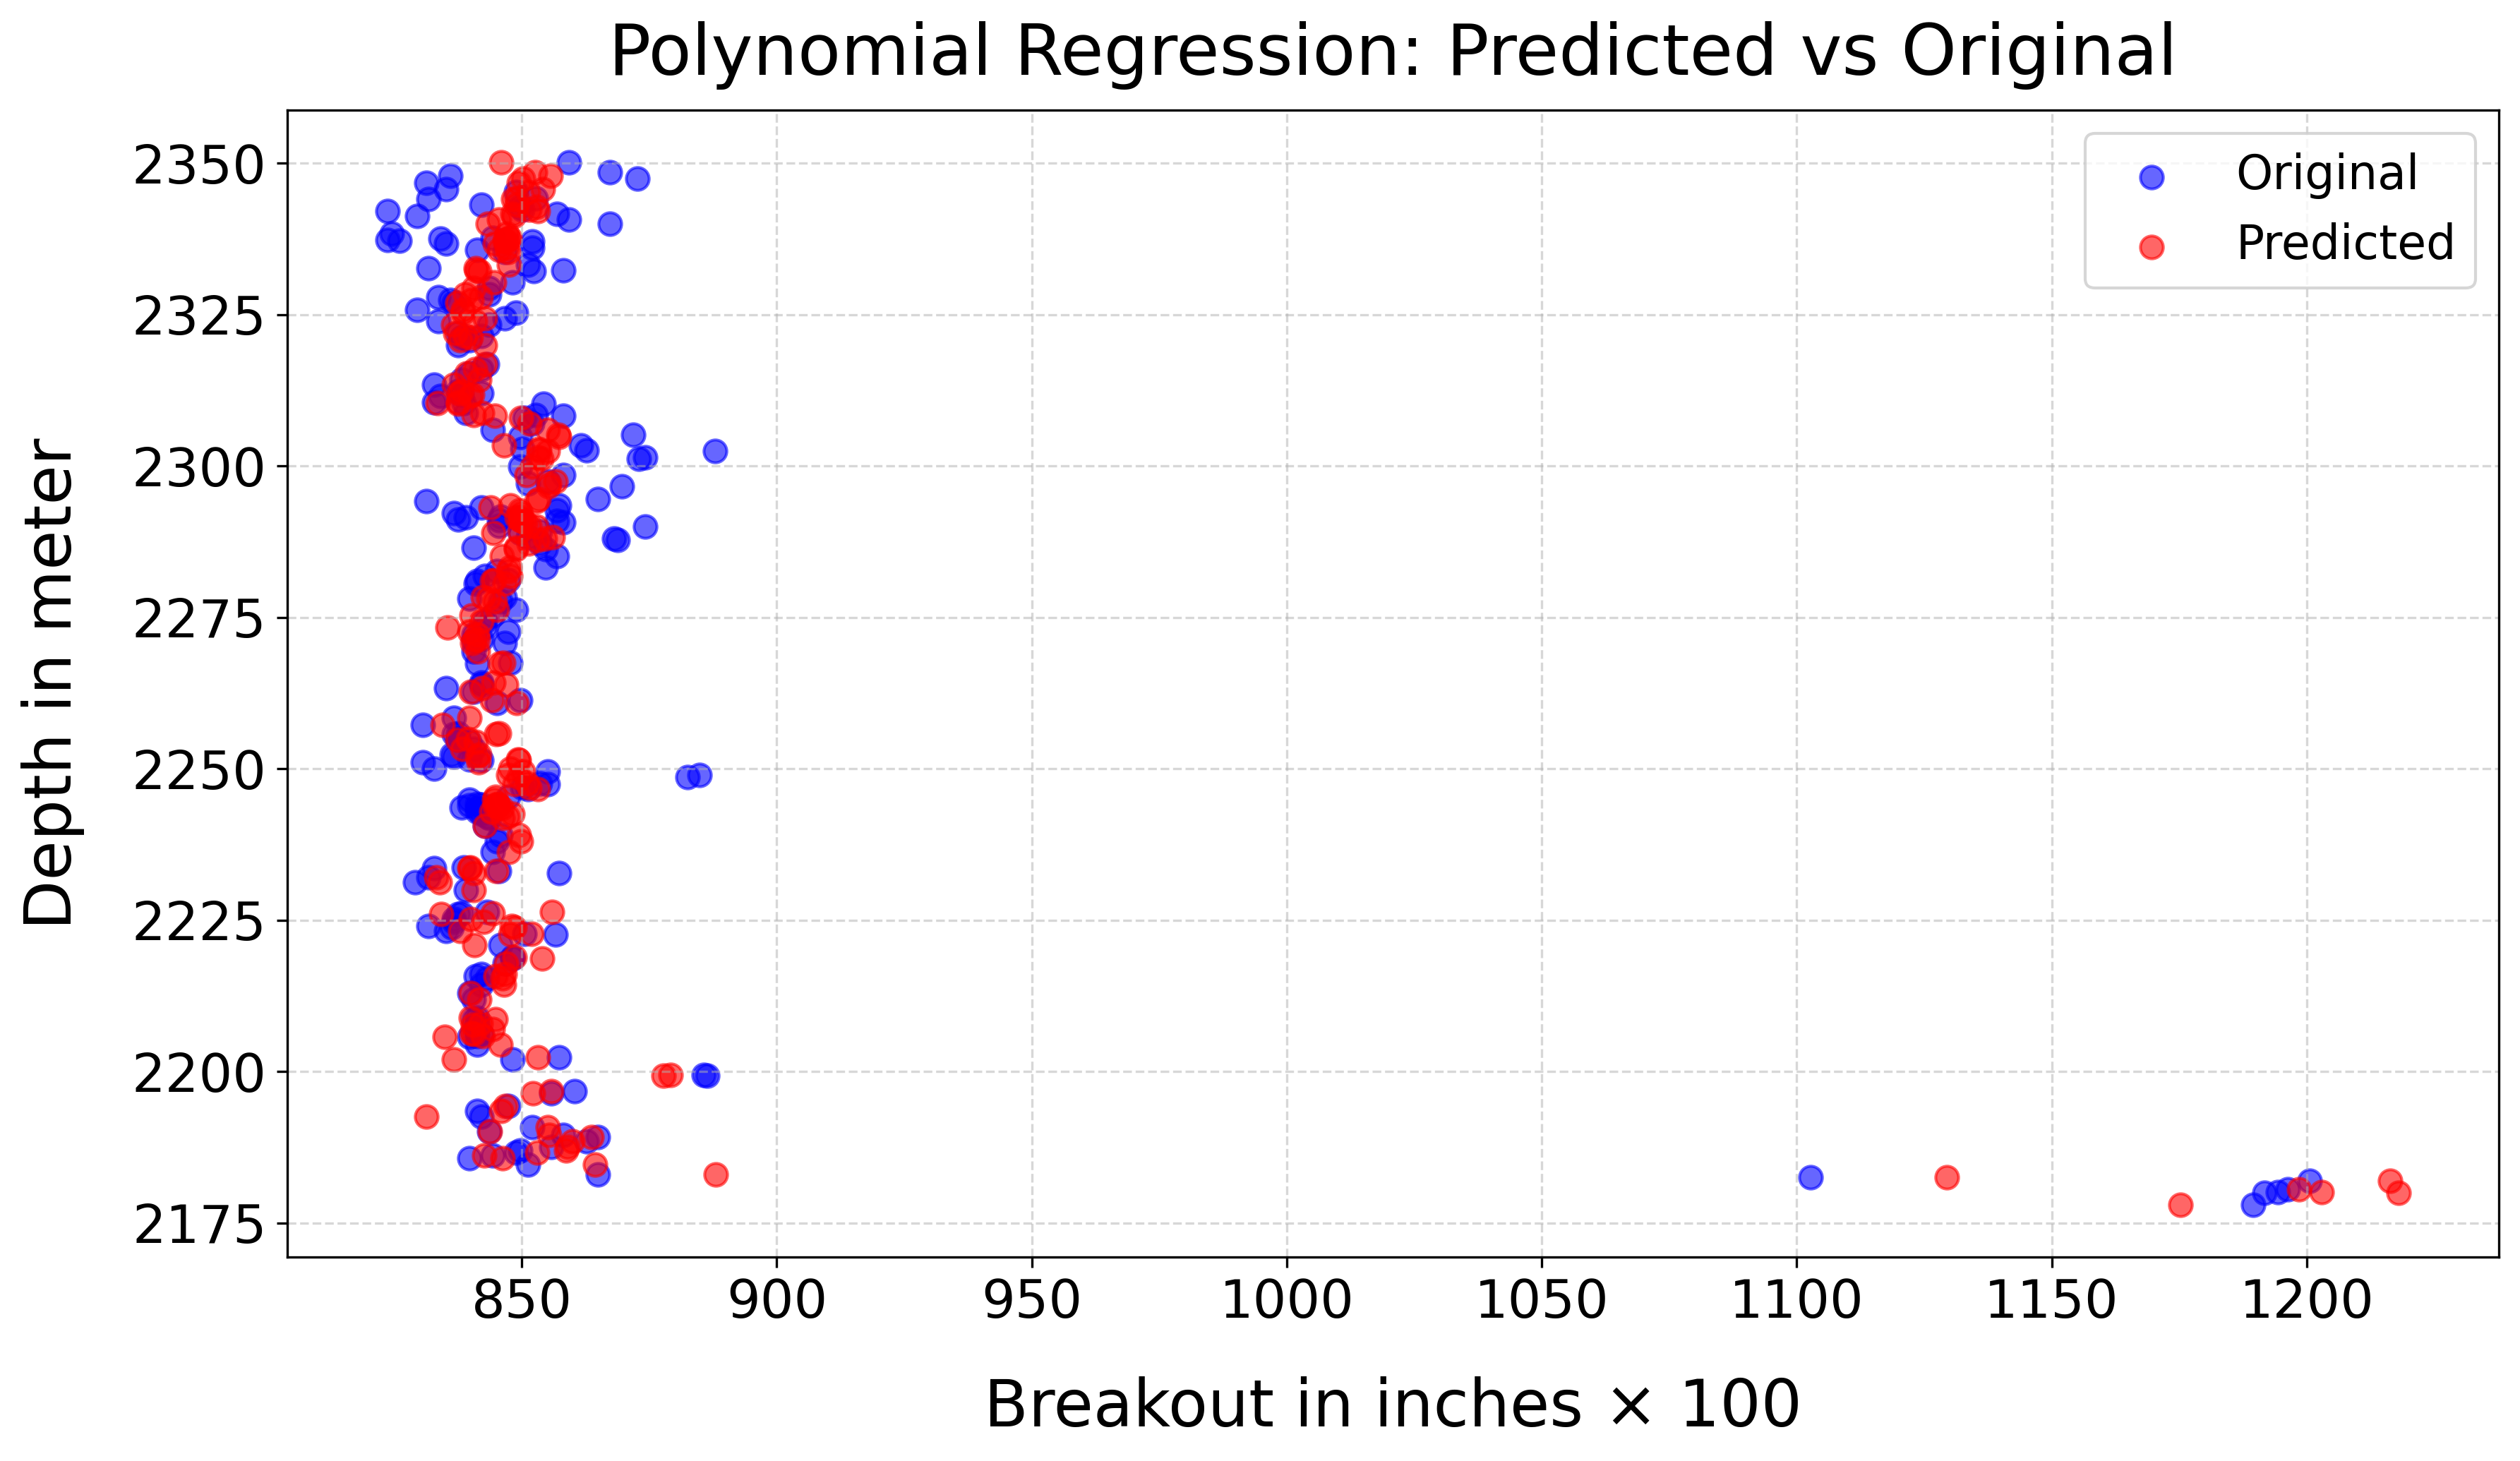

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Polynomial Feature Transformation (Degree 2)
poly_reg = PolynomialFeatures(degree=2)
X_polyt = poly_reg.fit_transform(X_Train)     # Transformed training data
X_polytest = poly_reg.transform(X_Test)       # Transformed testing data

# Step 2: Train Polynomial Regression Model
lin_reg = LinearRegression()
lin_reg.fit(X_polyt, Y_Train)
Y_Predpoly = lin_reg.predict(X_polytest)

# Step 3: SHAP Explainer (on transformed feature space)
shap.initjs()
explainer = shap.Explainer(lin_reg, X_polyt)
shap_values = explainer(X_polytest)

# Step 4: SHAP Visualizations
shap.summary_plot(shap_values, X_polytest, feature_names=poly_reg.get_feature_names_out(X_Train.columns))
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# Step 5: Convert SHAP values to DataFrame and compute mean
shap_values_df = pd.DataFrame(shap_values.values, columns=poly_reg.get_feature_names_out(X_Train.columns))
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)

# Export mean SHAP values to CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("mean_shap_values_polynomial.csv", index=False)
print(mean_shap_values)

# Step 6: Plot - Predicted vs Original (vs Depth)
plt.figure(figsize=(12, 7), dpi=300)

# Use original depth from X_Test (assumes depth is in the first column)
depths = X_Test.iloc[:, 0]

# Scatter plot
plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(Y_Predpoly, depths, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("Polynomial Regression: Predicted vs Original", fontsize=24, pad=12)

# Ticks and layout
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig("Polynomial_Regression_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


GradientBoostingRegressor

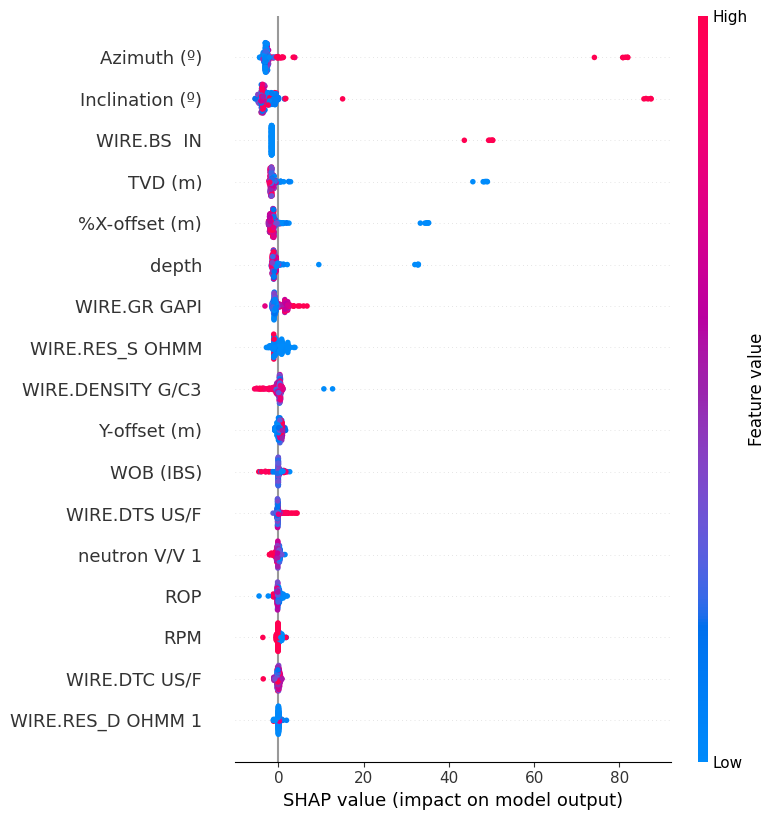

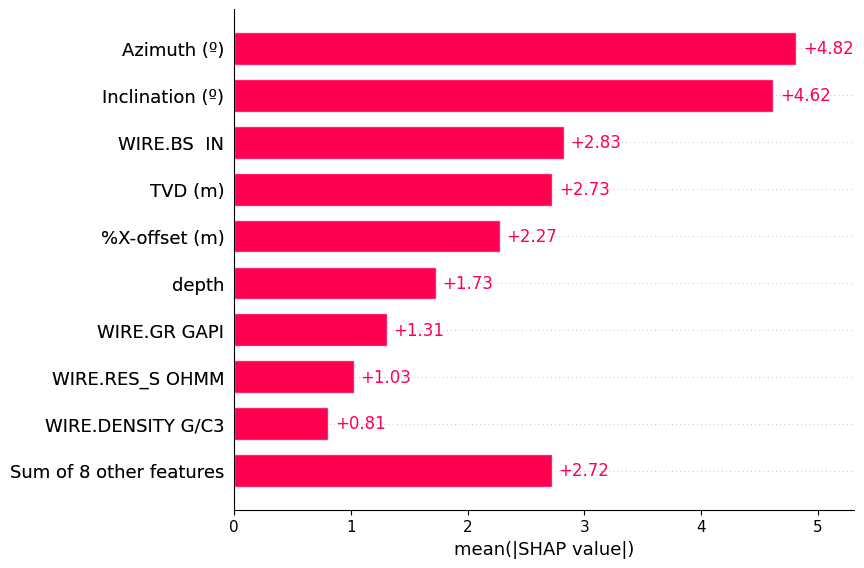

Inclination (º)     -0.630938
Azimuth (º)         -0.459010
%X-offset (m)       -0.326100
WIRE.BS  IN         -0.257216
WIRE.DENSITY G/C3   -0.172798
neutron V/V 1       -0.142768
depth               -0.140217
TVD (m)             -0.090055
WIRE.DTC US/F       -0.059138
ROP                  0.013595
WIRE.RES_S OHMM      0.019496
WIRE.RES_D OHMM 1    0.024912
WIRE.DTS US/F        0.071644
WOB (IBS)            0.075790
RPM                  0.081233
WIRE.GR GAPI         0.169717
Y-offset (m)         0.340399
dtype: float64


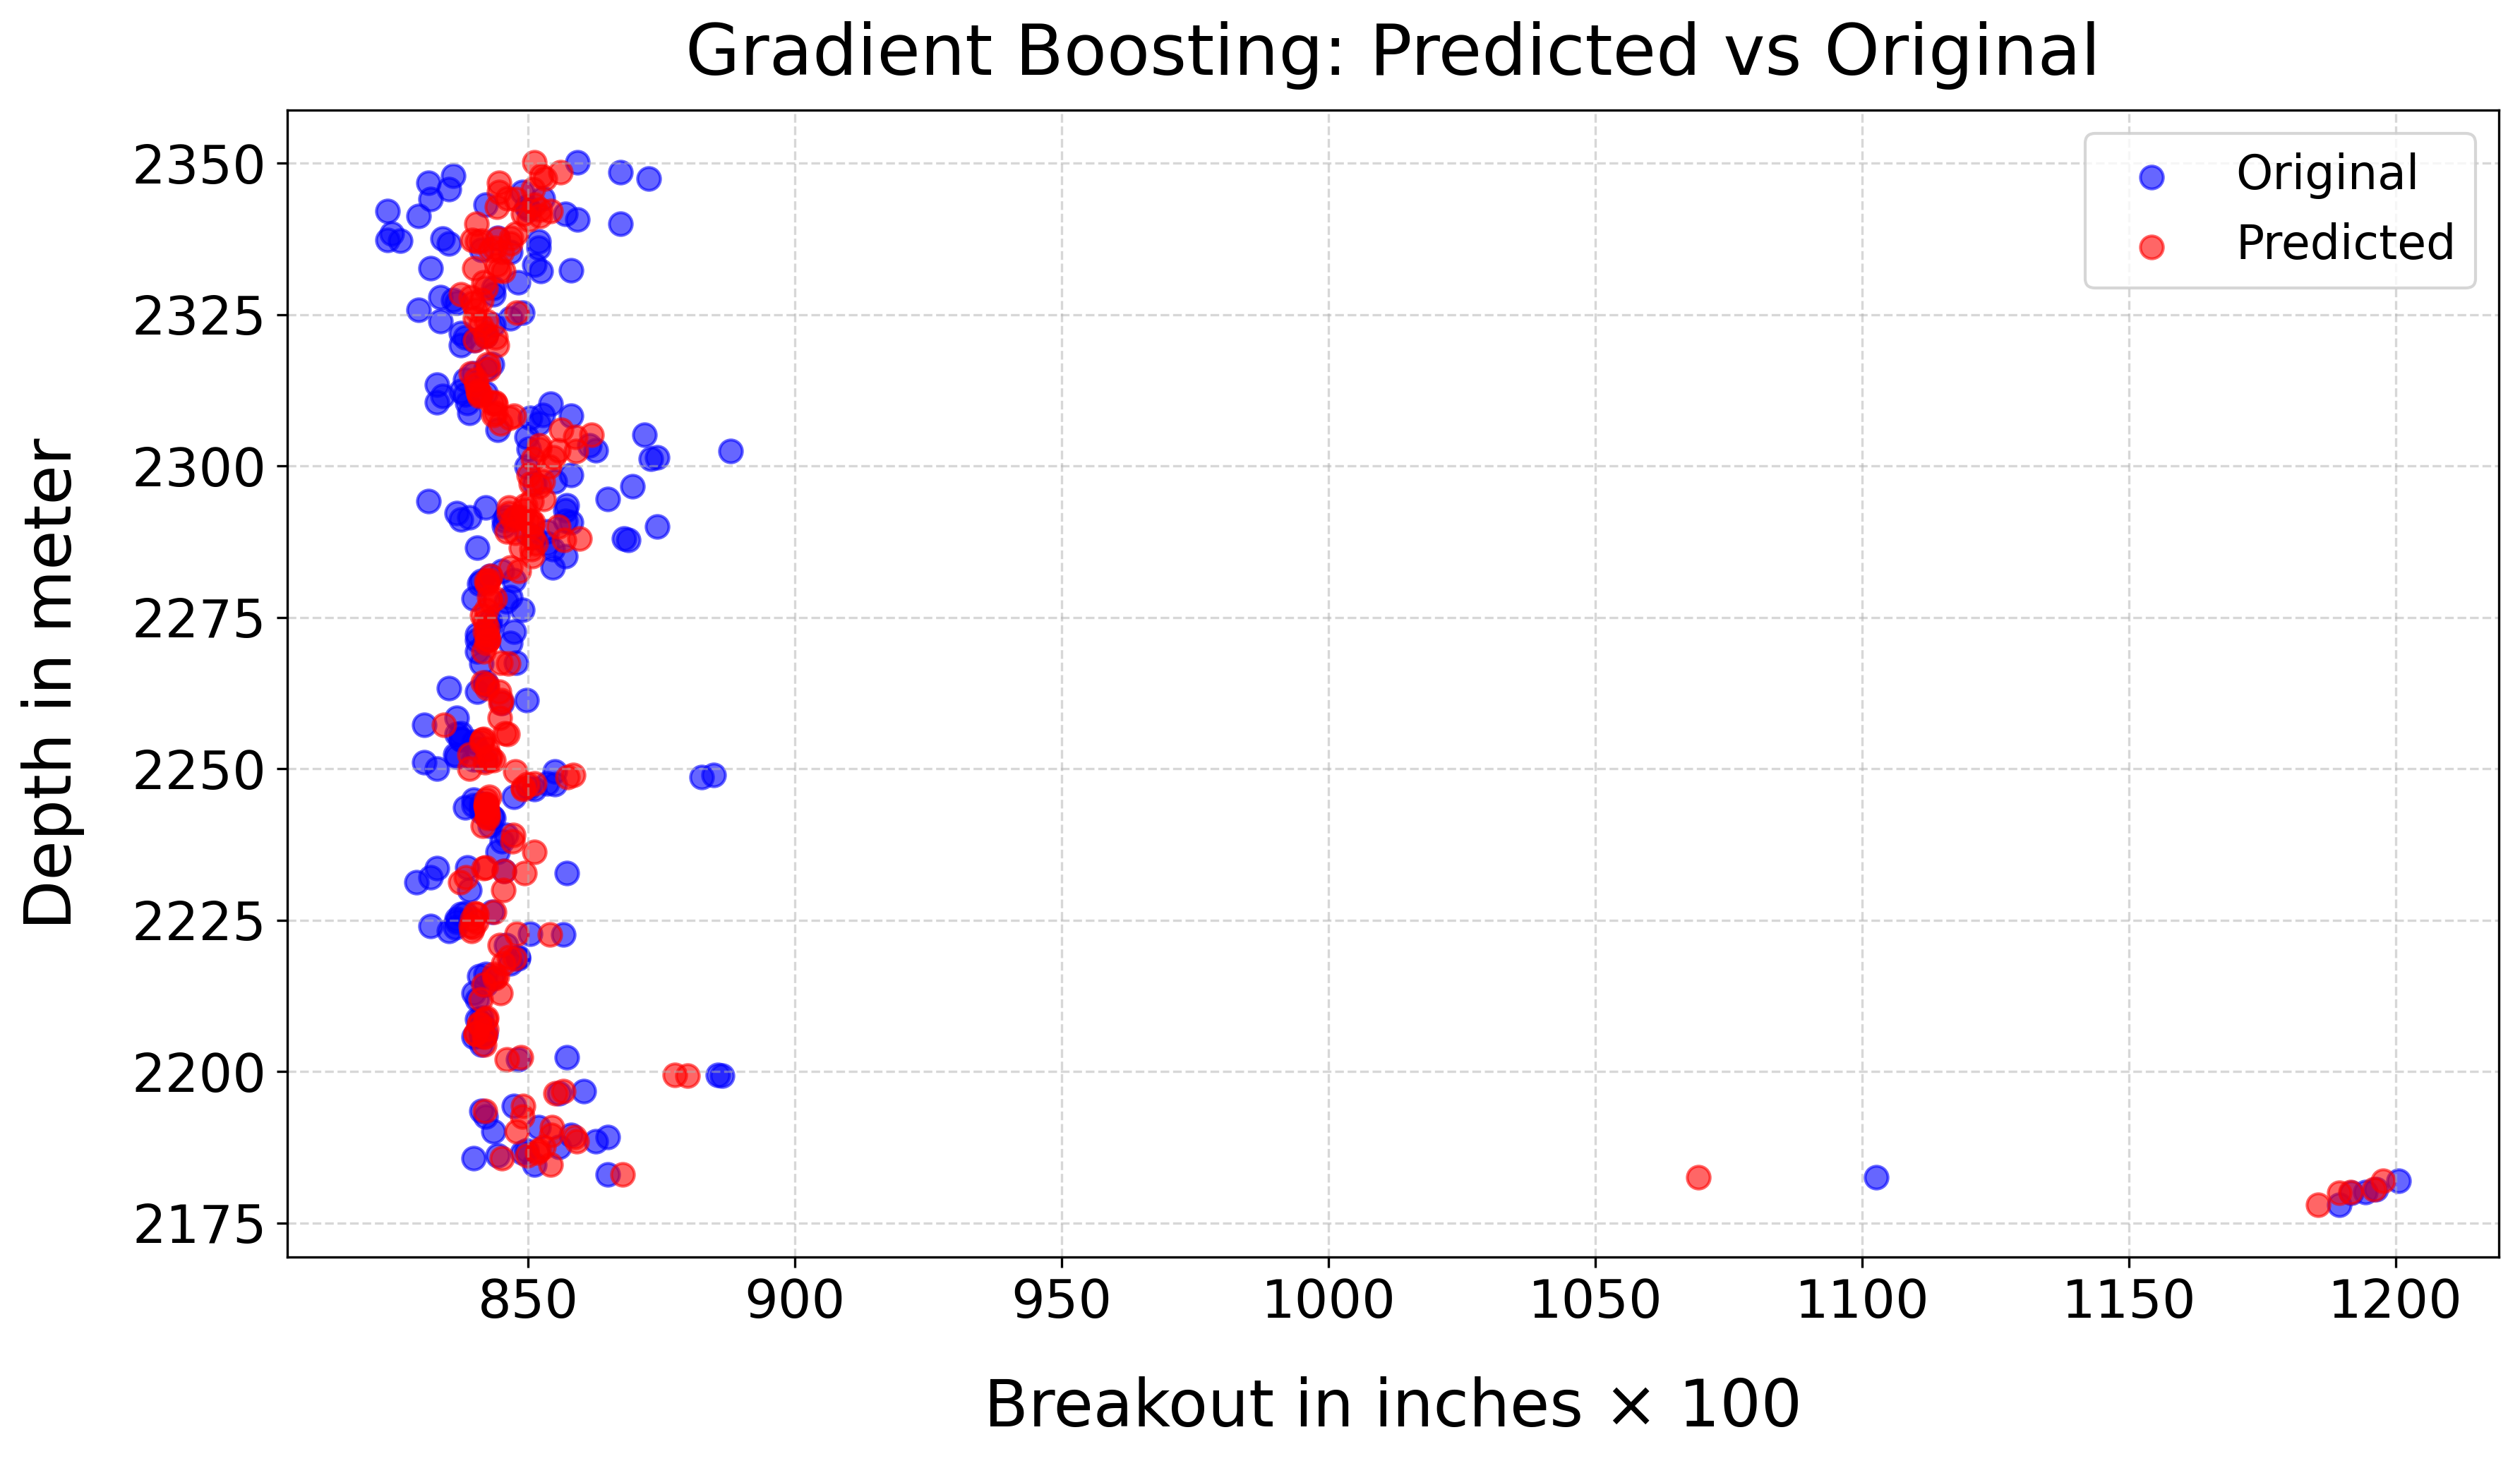

In [4]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Model with custom parameters
gbr = GradientBoostingRegressor(
    n_estimators=600,
    max_depth=5,
    learning_rate=0.01,
    min_samples_split=3,
    random_state=42
)

# Fit model
gbr.fit(X_Train, Y_Train)
Y_PredGBR = gbr.predict(X_Test)

# SHAP analysis
explainer = shap.Explainer(gbr)
shap_values = explainer(X_Test)

# Initialize SHAP JS
shap.initjs()

# SHAP visualizations
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Individual force plot

# Export SHAP values
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Test.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)

# Save to CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv('mean_shap_values.csv', index=False)
print(mean_shap_values)

# Plot: GBR Predicted vs Original
plt.figure(figsize=(12, 7), dpi=300)

# Depth from original feature space
depths = X_Test.iloc[:, 0]

# Scatter plot
plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(Y_PredGBR, depths, s=60, color="red", label="Predicted", alpha=0.6)

plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("Gradient Boosting: Predicted vs Original", fontsize=24, pad=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("GradientBoosting_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Gaussian Process Regression

In [ ]:
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel

# Define and train the GPR model
kernel = DotProduct() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=0)
gpr.fit(X_Train, Y_Train)

# Predict
Y_Pregpr = gpr.predict(X_Test)

# SHAP Explainer
shap.initjs()
explainer = shap.Explainer(gpr.predict, X_Test)
shap_values = explainer(X_Test)

# SHAP Visualizations
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# Average SHAP value per feature
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Test.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)

# Save SHAP values
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("GPR_mean_shap_values.csv", index=False)
print(mean_shap_values)

# Plot: GPR Predicted vs Original
plt.figure(figsize=(12, 7), dpi=300)

# Use depth from X_Test (assuming first column is depth)
depths = X_Test.iloc[:, 0]

plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(Y_Pregpr, depths, s=60, color="red", label="Predicted", alpha=0.6)

plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("GPR: Predicted vs Original", fontsize=24, pad=12)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show the plot
plt.savefig("GPR_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


PermutationExplainer explainer:  23%|██▎       | 53/228 [02:47<08:45,  3.00s/it]

Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
import shap
import matplotlib.pyplot as plt
import pandas as pd

# Convert target to integer for classification
Y_Train = Y_Train.astype('int')
Y_Test = Y_Test.astype('int')

# Train Gaussian Naive Bayes model
gnb = GaussianNB()
gnb.fit(X_Train, Y_Train)
y_pred = gnb.predict(X_Test)

# SHAP Explanation
shap.initjs()
explainer = shap.Explainer(gnb.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP Plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# SHAP value summary
shap_values_df = pd.DataFrame(shap_values.values, columns=X.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Save SHAP values as CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("GNB_mean_shap_values.csv", index=False)

# Plot: Predicted vs Original (classification)
plt.figure(figsize=(12, 7), dpi=300)

# Depth is assumed to be the first feature
depths = X_Test.iloc[:, 0]

plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depths, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and Title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("GNB: Predicted vs Original (Classification)", fontsize=24, pad=12)

# Scale numbers
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

# Legend and Grid
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show the plot
plt.savefig("GNB_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Bernoulli Naive Bayes

In [ ]:
from sklearn.naive_bayes import BernoulliNB
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Ensure Y_Train is integer for classification
Y_Train = Y_Train.astype('int')
Y_Test = Y_Test.astype('int')

# Instantiate and train BernoulliNB model
bnb = BernoulliNB()
bnb.fit(X_Train, Y_Train)

# Predict on test data
y_pred = bnb.predict(X_Test)

# SHAP Explanation
shap.initjs()
explainer = shap.Explainer(bnb.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP Plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# SHAP value summary
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Save SHAP values to CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("BernoulliNB_mean_shap_values.csv", index=False)

# Plot: Predicted vs Original (classification)
plt.figure(figsize=(12, 7), dpi=300)

# Use depth as Y-axis (assumed to be first column)
depths = X_Test.iloc[:, 0]

# Scatter plots
plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depths, s=60, color="red", label="Predicted", alpha=0.6)

# Axis labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("BernoulliNB: Predicted vs Original (Classification)", fontsize=24, pad=12)

# Ticks and formatting
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig("BernoulliNB_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Support Vector Regression

In [ ]:
from sklearn.svm import SVR
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and train SVR model
svr = SVR()
svr.fit(X_Train, Y_Train)

# Predict using SVR model
y_pred = svr.predict(X_Test)

# SHAP explanation
shap.initjs()
explainer = shap.Explainer(svr.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# Convert SHAP values to DataFrame and compute mean
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Save SHAP values to CSV
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("SVR_mean_shap_values.csv", index=False)

# Plot: Predicted vs Original
plt.figure(figsize=(12, 7), dpi=300)

# Use depth as Y-axis (assumed to be the first column of X_Test)
depths = X_Test.iloc[:, 0]

# Scatter plot
plt.scatter(Y_Test, depths, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depths, s=60, color="red", label="Predicted", alpha=0.6)

# Axis labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("SVR: Predicted vs Original", fontsize=24, pad=12)

# Ticks and layout
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig("SVR_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Random Forest Regression model

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and fit the RandomForestRegressor model
rfr = RandomForestRegressor(random_state=0)
rfr.fit(X_Train, Y_Train)

# Predict on the test set
y_pred = rfr.predict(X_Test)

# SHAP Explainer
shap.initjs()
explainer = shap.Explainer(rfr.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP summary and bar plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Force plot for first sample

# Convert SHAP values to DataFrame for mean SHAP analysis
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Save SHAP mean values to CSV (optional)
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("RandomForest_Mean_SHAP_Values.csv", index=False)

# Plot: Predicted vs Original (Depth vs Breakout)
plt.figure(figsize=(12, 7), dpi=300)

depth = X_Test.iloc[:, 0]  # Assuming first column is Depth

# Scatter plots
plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and styling
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("Random Forest: Predicted vs Original", fontsize=24, pad=12)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and display
plt.savefig("RandomForest_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Decision Tree Regressor

In [ ]:
from sklearn.tree import DecisionTreeRegressor
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and fit the DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_Train, Y_Train)

# Predict using the test data
y_pred = dtr.predict(X_Test)

# Initialize SHAP explainer
shap.initjs()
explainer = shap.Explainer(dtr.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])

# Mean SHAP value analysis
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Save mean SHAP values to CSV (optional)
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("DecisionTree_Mean_SHAP_Values.csv", index=False)

# Plot: Predicted vs Original (Depth vs Breakout)
plt.figure(figsize=(12, 7), dpi=300)

depth = X_Test.iloc[:, 0]  # Assuming first column is Depth

plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labeling
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("Decision Tree: Predicted vs Original", fontsize=24, pad=12)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig("DecisionTree_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Multi-layer Perceptron (MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and train MLPRegressor
mlp = MLPRegressor(random_state=0, max_iter=1000)  # Added reproducibility and sufficient iterations
mlp.fit(X_Train, Y_Train)

# Predict on test data
y_pred = mlp.predict(X_Test)

# SHAP explanation
shap.initjs()
explainer = shap.Explainer(mlp.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Visualize for first test instance

# Convert SHAP values to DataFrame and calculate means
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Export mean SHAP values (optional)
mean_shap_values_df = pd.DataFrame({
    'Feature': mean_shap_values.index,
    'Mean SHAP Value': mean_shap_values.values
})
mean_shap_values_df.to_csv("MLP_Mean_SHAP_Values.csv", index=False)

# Plot: Predicted vs Original (Breakout vs Depth)
plt.figure(figsize=(12, 7), dpi=300)

depth = X_Test.iloc[:, 0]  # Assuming first column represents depth
plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labeling
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("MLP Regressor: Predicted vs Original", fontsize=24, pad=12)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show
plt.savefig("MLP_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Histogram Gradient Boosting

In [ ]:
from sklearn.ensemble import HistGradientBoostingRegressor
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and train the HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(random_state=0)
hgb.fit(X_Train, Y_Train)

# Predict on test data
y_pred = hgb.predict(X_Test)

# SHAP explanation
shap.initjs()
explainer = shap.Explainer(hgb.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Force plot for the first test instance

# Convert SHAP values to DataFrame and calculate means
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Plot: Predicted vs Original (Breakout vs Depth)
plt.figure(figsize=(12, 7), dpi=300)

depth = X_Test.iloc[:, 0]  # Assuming the first feature column is depth
plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("HGB Regressor: Predicted vs Original", fontsize=24, pad=12)

# Tick sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show plot
plt.savefig("HGB_Regressor_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()


Nearest Neighbors

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
import shap
import pandas as pd
import matplotlib.pyplot as plt

# Instantiate and fit the KNeighborsRegressor
knn = KNeighborsRegressor()
knn.fit(X_Train, Y_Train)

# Predict on test data
y_pred = knn.predict(X_Test)

# SHAP explanation
shap.initjs()
explainer = shap.Explainer(knn.predict, X_Train)
shap_values = explainer(X_Test)

# SHAP plots
shap.summary_plot(shap_values, X_Test)
shap.plots.bar(shap_values)
shap.plots.force(shap_values[0])  # Force plot for the first test instance

# Convert SHAP values to DataFrame and calculate means
shap_values_df = pd.DataFrame(shap_values.values, columns=X_Train.columns)
mean_shap_values = shap_values_df.mean().sort_values(ascending=True)
print(mean_shap_values)

# Plot: Predicted vs Original (Breakout vs Depth)
plt.figure(figsize=(12, 7), dpi=300)

depth = X_Test.iloc[:, 0]  # Assuming the first feature is depth
plt.scatter(Y_Test, depth, s=60, color="blue", label="Original", alpha=0.6)
plt.scatter(y_pred, depth, s=60, color="red", label="Predicted", alpha=0.6)

# Labels and title
plt.xlabel("Breakout in inches × 100", fontsize=22, labelpad=16)
plt.ylabel("Depth in meter", fontsize=22, labelpad=16)
plt.title("KNeighborsRegressor: Predicted vs Original", fontsize=24, pad=12)

# Tick sizes
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Save and show plot
plt.savefig("KNeighborsRegressor_Predicted_vs_Original.png", dpi=300, bbox_inches='tight')
plt.show()
